# First Tests of TDCCSD

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from quantum_systems import TwoDimensionalHarmonicOscillator
from quantum_systems.time_evolution_operators import LaserField

In [3]:
from coupled_cluster.ccsd import TDCCSD
from coupled_cluster.integrators import GaussIntegrator

In [4]:
class LaserPulse:
    
    def __init__(self, t_0=0, t_final=10, omega=8, strength=0.03):
        self.t_0 = t_0
        self.t_final = t_final
        self.omega = omega
        self.strength = strength
        
    def __call__(self, t):
        return self.strength * np.sin(self.omega * t)

In [5]:
# Parameter
n = 2
l = 20

radius = 8
num_grid_points = 401
omega = 1 / 6
mass = 1

tdho = TwoDimensionalHarmonicOscillator(n, l, radius, num_grid_points, omega, mass)
tdho.setup_system()
tdho.change_to_hf_basis(verbose=True, tolerance=1e-8)

HF converged to given precision in 7 iterations
Ehf: (0.7691492054660882+0j)


In [6]:
polarization_vector = np.zeros(2)
polarization_vector[0] = 1

laser = LaserField(
    LaserPulse(omega=8*omega, strength=0.5),
    polarization_vector=polarization_vector
)

tdho.set_time_evolution_operator(laser)

In [7]:
integrator = GaussIntegrator(np=np, eps=1e-10)
tdccsd = TDCCSD(tdho, np=np, integrator=integrator, verbose=True)

tdccsd.compute_ground_state()
print(f"Ground state energy: {tdccsd.compute_ground_state_energy()}")

Iteration: 0	Residuals (t): [0.003897014037069468, 0.16653061565795876]
Iteration: 1	Residuals (t): [0.007686094537642749, 0.06530850156515973]
Iteration: 2	Residuals (t): [0.0025030095799434865, 0.03477584026245654]
Iteration: 3	Residuals (t): [0.0009553061219245169, 0.019144504081123104]
Iteration: 4	Residuals (t): [0.0002493784243375071, 0.010921761619481996]
Iteration: 5	Residuals (t): [4.108379021863071e-05, 0.006280671097277585]
Iteration: 6	Residuals (t): [1.6886038485241595e-05, 0.003630081487916442]
Iteration: 7	Residuals (t): [2.4743452098144847e-05, 0.0021021537556605474]
Iteration: 8	Residuals (t): [2.0105973300803815e-05, 0.00121879011120101]
Iteration: 9	Residuals (t): [1.3895437782065214e-05, 0.0007071182546236699]
Iteration: 10	Residuals (t): [8.9513841139878e-06, 0.00041044955046195744]
Iteration: 11	Residuals (t): [5.555473967261207e-06, 0.00023832520614693495]
Iteration: 12	Residuals (t): [3.3738977375361775e-06, 0.00013841522638381964]
Iteration: 13	Residuals (t): [

In [8]:
rho = tdccsd.compute_ground_state_particle_density()

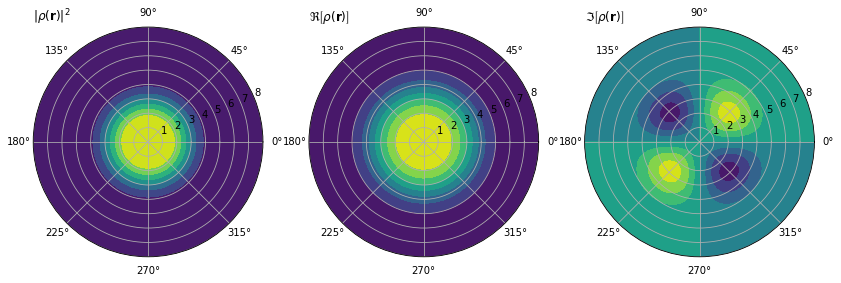

In [9]:
fig = plt.figure(figsize=(14, 10))

ax = fig.add_subplot(1, 3, 1, polar=True)
ax.set_title(r"$|\rho(\mathbf{r})|^2$", loc="left")
plt.contourf(tdho.T, tdho.R, np.abs(rho * rho.conj()))

ax = fig.add_subplot(1, 3, 2, polar=True)
ax.set_title(r"$\Re\left[\rho(\mathbf{r})\right]$", loc="left")
plt.contourf(tdho.T, tdho.R, rho.real)

ax = fig.add_subplot(1, 3, 3, polar=True)
ax.set_title(r"$\Im\left[\rho(\mathbf{r})\right]$", loc="left")
plt.contourf(tdho.T, tdho.R, rho.imag)
plt.show()

## Time Development

In [10]:
tdccsd.set_initial_conditions()

In [11]:
num_timesteps = 801
t_end = 8
time_points = np.linspace(0, t_end, num_timesteps)

In [12]:
psi_overlap = np.zeros(num_timesteps, dtype=np.complex128)
td_energies = np.zeros(num_timesteps, dtype=np.complex128)
dip_z = np.zeros_like(td_energies)

psi_overlap[0] = tdccsd.compute_time_dependent_overlap()
td_energies[0] = tdccsd.compute_energy()

t, l = tdccsd.amplitudes
rho_qp = tdccsd.compute_one_body_density_matrix()
rho_qp = 0.5 * (rho_qp.conj().T + rho_qp)

In [13]:
step_final = num_timesteps - 1
plot_step_freq = 5

for i, amp in enumerate(tdccsd.solve(time_points)):
    step = i + 1
    print(100 * " ", end="\r")
    print(f"step = {step} / {step_final}", end="\r")
    # psi_overlap[i + 1] = tdccsd.compute_time_dependent_overlap()
    td_energies[i + 1] = tdccsd.compute_energy()

    if step % plot_step_freq == 0:
        rho = tdccsd.compute_particle_density()

        fig = plt.figure()
        ax = plt.subplot(projection="polar")
        ax.set_title(r"$|\rho(\mathbf{r})|^2$ " + str(step), loc="left")
        ax.contourf(tdho.T, tdho.R, np.abs(rho * rho.conj()))
    
        #plt.show()
        
        plt.savefig("./Figures/images/tdho" + str(step) + ".png", format="png")
        plt.close(fig)

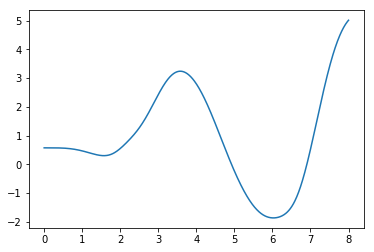

In [14]:
plt.plot(time_points, td_energies.real)
plt.show()

In [26]:
import imageio
import glob
import os
path = "./Figures/images/"
files = sorted([file for file in glob.glob(path + "tdho*.png")], key=os.path.getmtime)

In [28]:
images = []
for file in files:
    images.append(imageio.imread(file))
imageio.mimsave("./Figures/tdho.gif", images, duration=0.2)